# Analysis of the Word2Vec Algorithm on the Term Similarity Task -- Part 2: Bins

The **goal of this research** is to get a better understanding of the word2vec algorithm, to understand how the various hyperparameters affect the quality of the resulting models. Furthermore, we want to study, how corpus size affects model quality.
The research was done by **Pavel Glazyrin (pav.glazyrin@gmail.com)** in form of a Master thesis at ITMO University, St. Petersburg, under the supervision of **Dr. Gerhard Wohlgenannt**.

**Pavel Glazyrin** trained a large number of word2vec models on Wikipedia corpora of various sizes, with various training hyperparamters (in a grid search style, covering the whole hyperparameter space). We evaluate model quality with an **intrinsic evaluation** approach, using existing **word similarity** and **analogy** datasets.

In this notebook, we analyze the word similarity results, using popular datasets such as WordSim-353, SimLex-999, MEN, etc. We apply Pearson/Spearman correlation between the word similarity scores in the datasets (manually created gold standard), and the scores given by the word2vec models (using cosine similarity between the two terms).

((c) This notebook by Gerhard Wohlgenannt, 2020)

**For more details have a look at:
analysis_sim.ipynb
which is in the same folder!**



## Relevance of this work

This goal and relevance of this work is as follows:
* Better understand the theoretical and practical details of embedding models and their training parameters
* While pretrained embeddings are typically generated from large corpora such as Wikipedia, many domains have a very different vocabulary and use of language. For those domains, often the number of available training documents is limited. This is why the `word count` (**corpus size**) is a central parameter in this research -- in order to understand what corpus-size is necessary to train model of a certain quality.

## Bins

In this notebook we analyze the influence of **bins**, ie. the term frequency of the terms in the similarity datasets, on the evaluation (Spearman) score.

We use **four bins**:
* **Low frequency (word pairs):** if both words of the pair are in the **low** frequency range
* **Mid frequency (word pairs):** if both words of the pair are in the **mid** frequency range
* **High frequency (word pairs):** if both words of the pair are in the **high** frequency range
* **Mixed frequency (word pairs):** if both words of the pair are in the *different* frequency ranges, for example one word of the pair is in *low* frequency, and the second is in *mid* frequency. This is the most frequent case!


### How did we split into bins?
We order the words in the dataset by frequency of occurrence in the corpus. We than split them into 3 parts,
the 1/3 the words with the lowest frequency goes into the *low* part, the 1/3 with *medium* frequency goes into the *mid* part, and so on.

Finally, if both words of the pair are from the *low* frequency part, then we assign the pair to the *low frequency pair bin* -- and use the same strategy for *mid* and *high*. If a pair contains, for example, one word from the *low* frequency part, and one *mid* frequency words, then we assign it to the *mixed frequency bin*.


### What are "lower bound", "upper bound" and "pair count" in the result dataset?
**lower bound** is simply the lowest frequency in a given bin (resulting from splitting the words into 3 parts by frequency), and **upper bound** is the highest frequency in a bin.
For example, the *mid frequency bin* may go from word frequency 100 (lower bound) to 240 (upper bound). Words with a frequency below 100 or therefore in the low frequency bin. 
The **pair count** simple states how many word pairs from the similarity or analogy dataset are in a given bin.



## Step 1: Load the datafile and look at basic statistics

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# read that data file!
df = pd.read_csv('results.csv', index_col=0)
df.head()

,Embedding,Method,Time,Dimension,Window,Word count,Sampling,Cross-sentence,Epochs,Dataset,...,High bin upper bound,Low bin score,Low bin pair count,Middle bin score,Middle bin pair count,High bin score,High bin pair count,Mixed bin score,Mixed bin pair count,General score
0,w2v,CBOW,2020-05-06 02:47:27.506915,100,2,1000000,hs,No,100,MEN,...,1540,-0.086026,301,0.275763,230,0.458966,296,0.112565,2173,0.126147
1,w2v,CBOW,2020-05-06 02:47:27.820542,100,2,1000000,hs,No,100,MTurk,...,586,-0.107427,23,-0.085890,17,0.509618,27,0.204725,220,0.195639
2,w2v,CBOW,2020-05-06 02:47:28.132970,100,2,1000000,hs,No,100,RG65,...,186,NaN,5,-0.107143,7,0.800000,4,0.133621,49,0.189169
3,w2v,CBOW,2020-05-06 02:47:28.523470,100,2,1000000,hs,No,100,RW,...,1004,NaN,57,0.152343,77,0.515233,55,0.174082,1845,0.177550
4,w2v,CBOW,2020-05-06 02:47:28.867138,100,2,1000000,hs,No,100,SimLex-999,...,792,0.080735,91,0.032364,97,0.076347,173,0.099547,638,0.080024


### Structure of the Datafile

Which columns do we have, and what kind of data?

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 504 entries, 0 to 503
Data columns (total 26 columns):
Embedding                504 non-null object
Method                   504 non-null object
Time                     504 non-null object
Dimension                504 non-null int64
Window                   504 non-null int64
Word count               504 non-null int64
Sampling                 504 non-null object
Cross-sentence           504 non-null object
Epochs                   504 non-null int64
Dataset                  504 non-null object
Out of vocabulary        504 non-null int64
Low bin lower bound      504 non-null int64
Low bin upper bound      504 non-null int64
Mid bin lower bound      504 non-null int64
Mid bin upper bound      504 non-null int64
High bin lower bound     504 non-null int64
High bin upper bound     504 non-null int64
Low bin score            480 non-null float64
Low bin pair count       504 non-null int64
Middle bin score         504 non-null float64
Middl

In [3]:
df.describe()

,Dimension,Window,Word count,Epochs,Out of vocabulary,Low bin lower bound,Low bin upper bound,Mid bin lower bound,Mid bin upper bound,High bin lower bound,High bin upper bound,Low bin score,Low bin pair count,Middle bin score,Middle bin pair count,High bin score,High bin pair count,Mixed bin score,Mixed bin pair count,General score
count,504.000000,504.000000,5.040000e+02,504.0,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,480.000000,504.000000,504.000000,504.000000,504.000000,504.00000,504.000000,504.000000,504.000000
mean,200.000000,5.666667,5.333333e+06,100.0,406.404762,1.047619,36.738095,37.023810,156.857143,159.547619,3637.571429,0.168289,107.190476,0.339235,92.047619,0.489058,121.52381,0.303245,2028.380952,0.296496
std,100.099354,3.303110,3.685445e+06,0.0,643.274577,0.213170,38.463156,38.576142,136.833530,140.634156,3340.685927,0.220892,118.764864,0.279566,88.706262,0.217883,114.44941,0.197127,3118.996917,0.183613
min,100.000000,2.000000,1.000000e+06,100.0,0.000000,1.000000,3.000000,3.000000,13.000000,13.000000,142.000000,-0.785714,5.000000,-0.571429,7.000000,-0.400000,4.00000,0.047424,45.000000,0.046936
25%,100.000000,2.000000,1.000000e+06,100.0,6.000000,1.000000,9.000000,9.000000,38.000000,38.000000,792.000000,0.026465,22.000000,0.164255,21.000000,0.399365,27.00000,0.125694,123.000000,0.140605
50%,200.000000,5.000000,5.000000e+06,100.0,47.500000,1.000000,20.000000,22.000000,123.000000,124.000000,3006.500000,0.194250,91.000000,0.325511,84.500000,0.540970,94.00000,0.242842,625.500000,0.219695
75%,300.000000,10.000000,1.000000e+07,100.0,630.000000,1.000000,55.000000,56.000000,258.000000,258.000000,5662.000000,0.301637,109.000000,0.560042,121.000000,0.659766,179.00000,0.466155,1916.000000,0.469750
max,300.000000,10.000000,1.000000e+07,100.0,1798.000000,2.000000,169.000000,170.000000,611.000000,625.000000,15615.000000,0.900000,445.000000,0.874722,313.000000,0.900000,385.00000,0.774038,9527.000000,0.714991


In [4]:
df.shape, df[df.Embedding == 'w2v'].shape

((504, 26), (504, 26))

Ok, the previous cell shows us, that all enties in column Embedding == 'w2vv'

## Step 2: Simple Overall Comparison of Hyperparameters, based on "General Score" per frequency bin!!

In [14]:

# which statistics do we want to show? Per frequency bin -- in order to make results easier to read!

low_stats_dict = {'General score':  # column to look at 
              ['mean','median', 'max', 'min'], # functions to call
              'Low bin score':  # column to look at 
              ['mean','median', 'max', 'min'], # functions to call   
              'Low bin lower bound':  # column to look at 
              ['mean','median', 'max', 'min'], # functions to call    
              'Low bin upper bound':  # column to look at 
              ['mean','median', 'max', 'min'], # functions to call   
              'Low bin pair count':  # column to look at 
              ['mean','median', 'max', 'min'], # functions to cal
             }
middle_stats_dict = {'General score':  # column to look at 
              ['mean','median', 'max', 'min'], # functions to call
              'Middle bin score':  # column to look at
              ['mean','median', 'max', 'min'], # functions to call
              'Mid bin lower bound':  # column to look at
              ['mean','median', 'max', 'min'], # functions to call
              'Mid bin upper bound':  # column to look at
              ['mean','median', 'max', 'min'], # functions to call
              'Middle bin pair count':  # column to look at
              ['mean','median', 'max', 'min'], # functions to cal
             }
high_stats_dict = {'General score':  # column to look at 
              ['mean','median', 'max', 'min'], # functions to call
              'High bin score':  # column to look at 
              ['mean','median', 'max', 'min'], # functions to call
              'High bin lower bound':  # column to look at 
              ['mean','median', 'max', 'min'], # functions to call
              'High bin upper bound':  # column to look at 
              ['mean','median', 'max', 'min'], # functions to call
              'High bin pair count':  # column to look at 
              ['mean','median', 'max', 'min'], # functions to cal
             }
mixed_stats_dict = {'General score':  # column to look at 
              ['mean','median', 'max', 'min'], # functions to call
              'Mixed bin score':  # column to look at
              ['mean','median', 'max', 'min'], # functions to call
              'Mixed bin pair count':  # column to look at
              ['mean','median', 'max', 'min'], # functions to cal
             }

            
target_columns = ['General score', 'Low bin score', 'Middle bin score', 'High bin score', 'Mixed bin score', \
                  'Low bin lower bound', 'Low bin upper bound', 'Mid bin lower bound', 'Mid bin upper bound', \
                  'High bin lower bound', 'High bin upper bound', 'Low bin pair count', \
                  'Middle bin pair count', 'High bin pair count', 'Mixed bin pair count'
]

### **Analyze for the low frequency bin**: Effect of method (CBOW vs SG).

In [15]:
parameter_of_interest = "Method"
df[[parameter_of_interest]+target_columns].groupby(parameter_of_interest).agg(low_stats_dict)

General score                               Low bin score            \
                mean    median       max       min          mean    median   
Method                                                                       
CBOW        0.263089  0.192500  0.597169  0.046936      0.145997  0.169050   
SG          0.329903  0.234932  0.714991  0.075366      0.190582  0.229667   

                           Low bin lower bound                 \
             max       min                mean median max min   
Method                                                          
CBOW    0.900000 -0.785714            1.047619      1   2   1   
SG      0.659606 -0.642857            1.047619      1   2   1   

       Low bin upper bound                 Low bin pair count                  
                      mean median  max min               mean median  max min  
Method                                                                         
CBOW             36.738095     20  169   3         107.190476     91  445   5  
SG               36.738095     20  169   3         107.190476     91  445   5

We can see that **SG** is better than **COW**, and that **low frequency** word pairs have much worse than average (general score) results. 

General score (mean): **0.329903**  
Low freq score (mean): **0.190582**

Lower bound: 1 (mean)  
Upper bound: 36.7 (mean)  
Number of term pairs in low frequency bin: 107.2 (mean)

In [7]:
parameter_of_interest = "Method"
df[[parameter_of_interest]+target_columns].groupby(parameter_of_interest).agg(middle_stats_dict)

General score                               Middle bin score            \
                mean    median       max       min             mean    median   
Method                                                                          
CBOW        0.263089  0.192500  0.597169  0.046936          0.29894  0.294031   
SG          0.329903  0.234932  0.714991  0.075366          0.37953  0.355838   

                           Mid bin lower bound                  \
             max       min                mean median  max min   
Method                                                           
CBOW    0.863598 -0.571429            37.02381     22  170   3   
SG      0.874722 -0.500000            37.02381     22  170   3   

       Mid bin upper bound                 Middle bin pair count              \
                      mean median  max min                  mean median  max   
Method                                                                         
CBOW            156.857143    123  611  13             92.047619   84.5  313   
SG              156.857143    123  611  13             92.047619   84.5  313   

            
       min  
Method      
CBOW     7  
SG       7

We can see that **SG** is better than **COW**, and that **mid frequency** word pairs have a **better** than average (general score) results. 

General score (mean): **0.329903**  
Mid freq score (mean): **0.379538**

Lower bound: 37 (mean)  
Upper bound: 157 (mean)  
Number of term pairs in low frequency bin: 92.05 (mean)

**Interpretation**: 37-157 occurrences of words are already enough to get some useful, better than average, embeddings.


In [8]:
parameter_of_interest = "Method"
df[[parameter_of_interest]+target_columns].groupby(parameter_of_interest).agg(high_stats_dict)

General score                               High bin score            \
                mean    median       max       min           mean    median   
Method                                                                        
CBOW        0.263089  0.192500  0.597169  0.046936       0.438764  0.494427   
SG          0.329903  0.234932  0.714991  0.075366       0.539352  0.607143   

                           High bin lower bound                  \
             max       min                 mean median  max min   
Method                                                            
CBOW    0.837429 -0.400000           159.547619    124  625  13   
SG      0.900000  0.023545           159.547619    124  625  13   

       High bin upper bound                     High bin pair count         \
                       mean  median    max  min                mean median   
Method                                                                       
CBOW            3637.571429  3006.5  15615  142           121.52381     94   
SG              3637.571429  3006.5  15615  142           121.52381     94   

                 
        max min  
Method           
CBOW    385   4  
SG      385   4

We can see that **SG** is better than **COW**, and that **high frequency** word pairs have a **much better** than average (general score) results. (as expected!)

General score (mean): **0.329903**  
High freq score (mean): **0.539352** (!)

Lower bound: 160 (mean)  
Upper bound: 3637 (mean)  
Number of term pairs in low frequency bin: 121.052 (mean)

**Interpretation**: if a word occurs more than 160 times in the corpus, then the algorithm (w2v) has a lot of data points to create good embeddings for this word -- as seen by the high Spearman score (0.54) as compared to the gerneral avg scores (0.33).


In [9]:
parameter_of_interest = "Method"
df[[parameter_of_interest]+target_columns].groupby(parameter_of_interest).agg(mixed_stats_dict)

General score                               Mixed bin score            \
                mean    median       max       min            mean    median   
Method                                                                         
CBOW        0.263089  0.192500  0.597169  0.046936        0.271829  0.223097   
SG          0.329903  0.234932  0.714991  0.075366        0.334661  0.262298   

                           Mixed bin pair count                   
             max       min                 mean median   max min  
Method                                                            
CBOW    0.663812  0.063523          2028.380952  625.5  9527  45  
SG      0.774038  0.047424          2028.380952  625.5  9527  45

We can see that **SG** is better than **COW**, and that **mixed frequency** word pairs have about **same score** as the average (general score) results. 

General score (mean): **0.329903**  
High freq score (mean): **0.334661** (!)

Lower bound: 160 (mean)  
Upper bound: 3637 (mean)  
Number of term pairs in low frequency bin: **2028 (!)** (mean)

**Interpretation**: the vast majority of terms pairs falls into this category, therefore it is expected that the results are close to the general score (as the general score is largely influenced by the mixed pairs) -- and furthermore, the mixed pairs, are (well) a mix of low/mid/high frequency words, so also this create rather average results.

**Overall Interpretation**: overall Skip-Gram clearly is better for all Bins.
With regards to the bins, the results are as expected, lower numbers in apprearance lead to low quality vectors.


---

### General Overview of Bins: min, mean, max, mode (for SG models)

Here we visualize the scores for the various **bins**. Note that for low frequency word pairs in some cases we even get a negative correlation -- showing that for those the embedding quality is not sufficient!

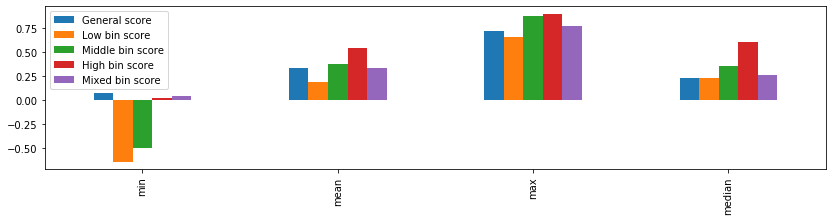

In [10]:
df1 = df.loc[df['Method']=='SG', :]
df1[['General score', 'Low bin score', 'Middle bin score', 'High bin score', 'Mixed bin score']] \
    .agg(['min', 'mean', 'max', 'median']) \
    .plot.bar(figsize=(14,3))

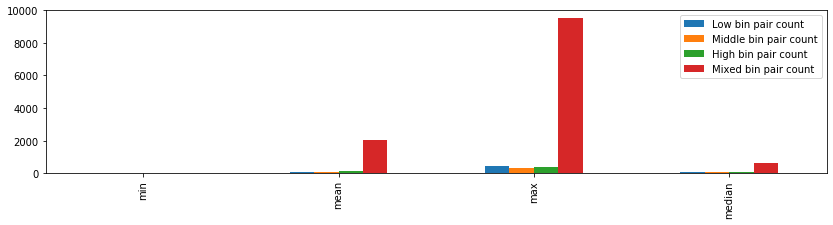

In [11]:
df1 = df.loc[df['Method']=='SG', :]
df1[['Low bin pair count', 'Middle bin pair count', 'High bin pair count', 'Mixed bin pair count']] \
    .agg(['min', 'mean', 'max', 'median']) \
    .plot.bar(figsize=(14,3))

**Interpretation**: unfortunaly, the vast majority of term pairs falls into the mixed-pair category


---

### Let's look at the distribution of number of term-pairs into bins per dataset! 

In [19]:
parameter_of_interest = "Dataset"
df1 = df.loc[df['Method']=='SG', :]

df1[[parameter_of_interest, 'Low bin pair count', 'Middle bin pair count', 'High bin pair count', 'Mixed bin pair count']] \
    .groupby(parameter_of_interest) \
    .agg(['min', 'mean', 'max', 'median'])

Low bin pair count                         Middle bin pair count  \
                          min        mean  max median                   min   
Dataset                                                                       
MEN                       301  372.000000  445  383.0                   230   
MTurk                      18   21.166667   23   21.5                    17   
RG65                        5    6.166667    7    6.5                     7   
RW                         54   86.666667  107   99.0                    76   
SimLex-999                 91   96.000000  102   97.0                    90   
TR9856                    106  136.000000  153  148.0                    79   
WS353                      29   32.333333   34   33.0                    19   

                                   High bin pair count                   \
                  mean  max median                 min        mean  max   
Dataset                                                                   
MEN         280.166667  313  288.0                 296  349.166667  385   
MTurk        20.833333   25   21.0                  27   30.166667   34   
RG65          7.166667    8    7.0                   4    5.833333    7   
RW          111.666667  137  122.0                  55   92.000000  128   
SimLex-999   96.333333  101   96.5                 168  179.666667  192   
TR9856      105.666667  123  110.0                 144  167.166667  179   
WS353        22.500000   25   22.5                  25   26.666667   29   

                  Mixed bin pair count                             
           median                  min         mean   max  median  
Dataset                                                            
MEN         367.5                 1882  1998.666667  2173  1936.0  
MTurk        30.0                  206   214.833333   220   215.5  
RG65          6.0                   45    45.833333    49    45.0  
RW           94.0                 1665  1743.666667  1849  1716.5  
SimLex-999  179.5                  610   627.000000   646   625.5  
TR9856      175.5                 9403  9447.166667  9527  9421.5  
WS353        26.5                  115   121.500000   129   121.0

For example for the MEN dataset (3000 word pairs), we have the following *mean* number of term pairs in the results:

Low freq pairs: 372  
Mid freq pairs: 280  
High freq pairs: 349  
Mixed freq pairs: 1998

So, 2/3 of word pairs are in the *mixed* category.


### Influence of `corpus size` on results per bin

In [21]:
parameter_of_interest = "Word count"
df1 = df.loc[df['Method']=='SG', :]

df1[[parameter_of_interest, 'General score', 'Low bin score', 'Middle bin score', 'High bin score', 'Mixed bin score']] \
    .groupby(parameter_of_interest) \
    .agg(['mean'])

,General score,Low bin score,Middle bin score,High bin score,Mixed bin score
,mean,mean,mean,mean,mean
Word count,,,,,
1000000,0.229892,0.189878,0.297897,0.515841,0.205998
5000000,0.348847,0.204428,0.398273,0.544121,0.361459
10000000,0.410970,0.177339,0.442419,0.558095,0.436527


**Interpretation**: The general score is clearly improving with a larger training corpus. Interestingly, for the low frequency bin, the larger corpus did not help (maybe there are still many random effects when training from such few examples). The largest improvements we see for the *mid* and *mixed* bins, which benefit a lot from the larger corpus. The results for the high frequency bin are already very good for the small corpus, as we already have a decent number of occurrences in that corpus.

In [49]:
df2 = df1.reindex(index=range(252), columns=list(df.columns))
df2.reindex??


In [67]:
df1['Low bin upper bound'].value_counts().sort_values()
#.plot.bar()



17      6
81      6
78      6
75      6
73      6
65      6
55      6
47      6
44      6
37      6
145     6
169     6
23      6
34      6
14      6
11      6
29      6
95      6
20     12
8      12
7      12
6      12
83     12
4      12
3      12
41     18
10     18
9      24
Name: Low bin upper bound, dtype: int64